In [90]:
import pandas as pd
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting


/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [163]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")

In [2]:
clinical_file = 'data/clinical_data_prisma_VF.csv'
clinical_data = pd.read_csv(clinical_file)
clinical_data = clinical_data.iloc[:, [9,0,2,3,4,5,6,7,8,15]]
clinical_data.rename(columns = {'id_RM':'subject'}, inplace = True)


In [3]:
fmri_file = 'data/functional_strength_data.csv'
fmri_data = pd.read_csv(fmri_file)
fmri_data["time"]= fmri_data.project.str.slice(6,7)
fmri_data["time"]=fmri_data["time"].astype(int)
fmri_data = fmri_data.iloc[:,[414,416,415,417,*range(1,414)]]
fmri_data.rename(columns = {'group':'Group'}, inplace = True)
fmri_data.drop('project', inplace=True, axis=1)


## Edit clinical data

In [4]:
pd.set_option('display.max_rows', None)

#add same treatment in all times
l=["Group",'time','edad','gen','esc','dx','psc', 'Gravedad'] # column different from each row
clinical_data_f = pd.concat([clinical_data.drop(l,1).groupby('subject').transform('first'),clinical_data[l],clinical_data[['subject']]],axis=1).reindex(columns=clinical_data.columns)


In [5]:
# Remove TAB dx 2
clinical_data_f = clinical_data_f.loc[~((clinical_data_f["Group"]=='TAB')&(clinical_data_f["dx"]==2.0))]
 

In [126]:
clinical_data_f['project'] = 'prisma'+ clinical_data_f.time.astype(str)

clinical_data_f.loc[clinical_data_f.Group == 'CTR', 'project'] = "controles"

clinical_data_f['c_group'] = clinical_data_f['Group'] + '-' + clinical_data_f['project'] +'-' +'treatment' + clinical_data_f['treatment'].astype(str)
clinical_data_EQF = clinical_data_f[clinical_data_f.Group!='TAB']
clinical_data_TAB = clinical_data_f[clinical_data_f.Group!='EQF']


## Edit fmri data

In [127]:
fmri_data_EQF_i = fmri_data[fmri_data.Group=='EQF']
fmri_data_TAB_i = fmri_data[fmri_data.Group=='TAB']
fmri_data_CTR_i = fmri_data[fmri_data.Group=='CTRL']


## Z-score by subject

In [133]:
fmri_data_EQF_z = fmri_data[fmri_data.Group=='EQF']
fmri_data_TAB_z = fmri_data[fmri_data.Group=='TAB']
fmri_data_CTR_z = fmri_data[fmri_data.Group=='CTRL']
fmri_data_EQF_z.iloc[:,3:] = fmri_data_EQF_z.iloc[:,3:].apply(zscore,axis=1)
fmri_data_TAB_z.iloc[:,3:] = fmri_data_TAB_z.iloc[:,3:].apply(zscore,axis=1)
fmri_data_CTR_z.iloc[:,3:] = fmri_data_CTR_z.iloc[:,3:].apply(zscore,axis=1)

/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


## Normalize

In [134]:
fmri_data_EQF_n = fmri_data[fmri_data.Group=='EQF']
fmri_data_TAB_n = fmri_data[fmri_data.Group=='TAB']
fmri_data_CTR_n = fmri_data[fmri_data.Group=='CTRL']
fmri_data_EQF_n.iloc[:,3:] = preprocessing.StandardScaler().fit_transform(fmri_data_EQF_n.iloc[:,3:])
fmri_data_TAB_n.iloc[:,3:] = preprocessing.StandardScaler().fit_transform(fmri_data_TAB_n.iloc[:,3:])
fmri_data_CTR_n.iloc[:,3:] = preprocessing.StandardScaler().fit_transform(fmri_data_CTR_n.iloc[:,3:])


/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [135]:
fmri_data_EQF_n = pd.concat([fmri_data_EQF_n,fmri_data_CTR_n])
fmri_data_TAB_n = pd.concat([fmri_data_TAB_n,fmri_data_CTR_n])
fmri_data_EQF_z = pd.concat([fmri_data_EQF_z,fmri_data_CTR_z])
fmri_data_TAB_z = pd.concat([fmri_data_TAB_z,fmri_data_CTR_z])

In [136]:
fmri_data_EQF=fmri_data_EQF_z
fmri_data_TAB=fmri_data_TAB_z

In [151]:
clinical_image_df_EQF = pd.merge(fmri_data_EQF, clinical_data_EQF[['subject','Group','project','time','c_group','treatment','psc','dx','Gravedad']], how='left', on=['subject', 'time'])
all_data_sorted_EQF = clinical_image_df_EQF.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups_EQF = all_data_sorted_EQF.groupby(['c_group']).count()
groups_dict_EQF = count_groups_EQF['subject'].to_dict()

list_len_EQF = list(groups_dict_EQF.values())
groups_EQF = list(groups_dict_EQF.keys())
groups_dict_EQF

{'CTR-controles-treatment0.0': 16,
 'EQZ-prisma1-treatment1.0': 10,
 'EQZ-prisma1-treatment2.0': 6,
 'EQZ-prisma3-treatment1.0': 10,
 'EQZ-prisma3-treatment2.0': 6}

In [152]:
clinical_image_df_TAB = pd.merge(fmri_data_TAB, clinical_data_TAB[['subject','Group', 'project','time','c_group','treatment','psc','dx','Gravedad']], how='left', on=['subject', 'time'])
all_data_sorted_TAB = clinical_image_df_TAB.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
all_data_sorted_TAB = all_data_sorted_TAB.iloc[:-2,:]

count_groups_TAB = all_data_sorted_TAB.groupby(['c_group']).count()
groups_dict_TAB = count_groups_TAB['subject'].to_dict()

list_len_TAB = list(groups_dict_TAB.values())
groups_TAB = list(groups_dict_TAB.keys())
groups_dict_TAB

{'CTR-controles-treatment0.0': 16,
 'TAB-prisma1-treatment1.0': 17,
 'TAB-prisma1-treatment2.0': 13,
 'TAB-prisma3-treatment1.0': 19,
 'TAB-prisma3-treatment2.0': 18}

In [216]:
X_EQF = all_data_sorted_EQF.iloc[:,3:-7].values
X_TAB = all_data_sorted_TAB.iloc[:,3:-7].values

In [217]:
random_state=42
pls_EQF = pyls.meancentered_pls(X_EQF, groups=list_len_EQF, seed=42, n_proc='max')

/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pyls-0.0.1-py3.7.egg/pyls/types/meancentered.py:32: UserWarning: Cannot set mean_centering to 0 when there is only one condition. Resetting mean_centering to 1.
  warnings.warn('Cannot set mean_centering to 0 when there is only '
Making bootstraps:   5%|5         | 263/5000 | 00:00<00:13    /Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pyls-0.0.1-py3.7.egg/pyls/base.py:154: UserWarning: WARNING: Duplicate bootstraps used.
  warnings.warn('WARNING: Duplicate bootstraps used.')


In [218]:
pvals_EQF = pls_EQF.permres['pvals']
x_weights_EQF = pls_EQF.bootres.x_weights_normed
y_weights_EQF = pls_EQF.y_weights
pvals_EQF

array([0.0039992 , 0.04279144, 0.78884223, 0.99880024, 0.99080184])

In [219]:
pls_TAB = pyls.meancentered_pls(X_TAB, groups=list_len_TAB, seed=42, n_proc='max')

/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pyls-0.0.1-py3.7.egg/pyls/types/meancentered.py:32: UserWarning: Cannot set mean_centering to 0 when there is only one condition. Resetting mean_centering to 1.
  warnings.warn('Cannot set mean_centering to 0 when there is only '


In [220]:
pvals_TAB = pls_TAB.permres['pvals']
x_weights_TAB = pls_TAB.bootres.x_weights_normed
y_weights_TAB = pls_TAB.y_weights
pvals_TAB

array([0.00519896, 0.01379724, 0.84943011, 0.97240552, 0.9870026 ])

In [238]:
y_loadings_df_EQF = pd.DataFrame({'1': y_weights_EQF[:,0], '2': y_weights_EQF[:,1], 'condition': groups_EQF,
                                'tratamiento': [group.split("-")[2] for group in groups_EQF] , 'time': [group.split("-")[1] for group in groups_EQF]})
y_loadings_m_EQF = pd.melt(y_loadings_df_EQF,id_vars=['condition','tratamiento','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_EQF['ci_l'] = np.concatenate([pls_EQF.bootres.contrast_ci[:,0,0], pls_EQF.bootres.contrast_ci[:,1,0]])
y_loadings_m_EQF['ci_u'] = np.concatenate([pls_EQF.bootres.contrast_ci[:,0,1], pls_EQF.bootres.contrast_ci[:,1,1]])

y_loadings_m_EQF['ci_l_p'] = y_loadings_m_EQF['weight'] - y_loadings_m_EQF['ci_l']
y_loadings_m_EQF['ci_u_p'] = y_loadings_m_EQF['weight'] - y_loadings_m_EQF['ci_u']
y_loadings_m_EQF['err'] = (y_loadings_m_EQF['ci_u'] - y_loadings_m_EQF['ci_l'])/2

In [240]:
y_loadings_df_TAB = pd.DataFrame({'1': y_weights_TAB[:,0], '2': y_weights_TAB[:,1], 'condition': groups_TAB,
                                  'tratamiento': [group.split("-")[2] for group in groups_TAB] , 'time': [group.split("-")[1] for group in groups_TAB]})
y_loadings_m_TAB = pd.melt(y_loadings_df_TAB,id_vars=['condition','tratamiento','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_TAB['ci_l'] = np.concatenate([pls_TAB.bootres.contrast_ci[:,0,0], pls_TAB.bootres.contrast_ci[:,1,0]])
y_loadings_m_TAB['ci_u'] = np.concatenate([pls_TAB.bootres.contrast_ci[:,0,1], pls_TAB.bootres.contrast_ci[:,1,1]])

y_loadings_m_TAB['ci_l_p'] = y_loadings_m_TAB['weight'] - y_loadings_m_TAB['ci_l']
y_loadings_m_TAB['ci_u_p'] = y_loadings_m_TAB['weight'] - y_loadings_m_TAB['ci_u']
y_loadings_m_TAB['err'] = (y_loadings_m_TAB['ci_u'] - y_loadings_m_TAB['ci_l'])/2

In [223]:
def errplot(x,y, yerr, **kwargs):
    data = kwargs.pop("data")
    plt.errorbar(x=x,y=data[y],yerr=data[yerr],fmt='none', c= 'k')

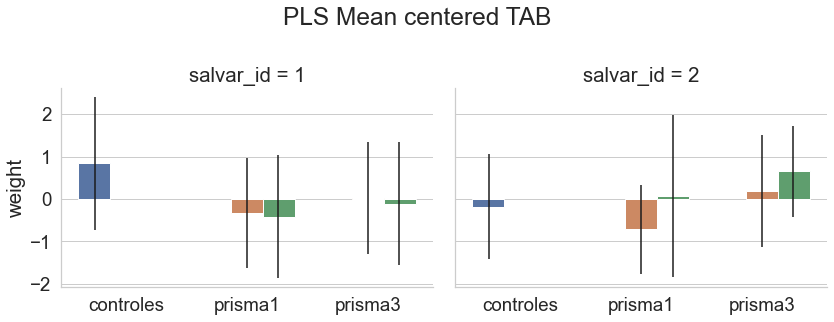

In [267]:
g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_TAB, legend=False)

g.map_dataframe(errplot,  [-0.26,1,1.26,2,2.26], "weight", "err")

plt.suptitle('PLS Mean centered TAB')

plt.tight_layout()
g.set_xlabels('')


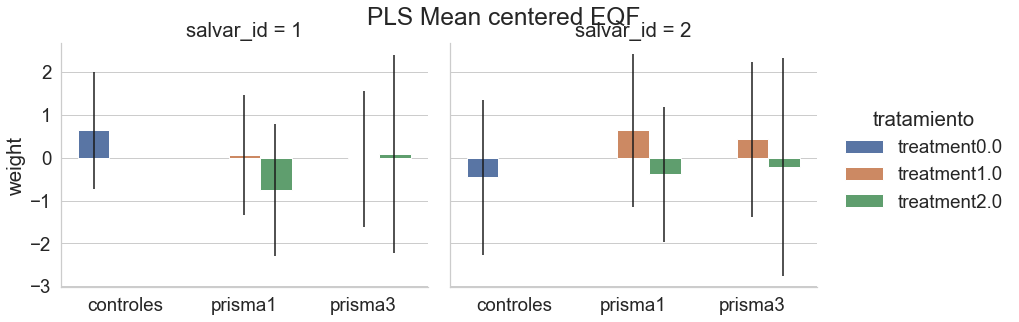

In [268]:
g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_EQF)

g.map_dataframe(errplot,  [-0.26,1,1.26,2,2.26], "weight", "err")

plt.suptitle('PLS Mean centered EQF')
g.set_xlabels('')


In [226]:
x_score_1_EQF=pls_EQF.x_scores
Y_score_1_EQF=pls_EQF.y_scores

score_EQF = pd.DataFrame()
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['grupo'] = all_data_sorted_EQF['Group_x']
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['project'] = all_data_sorted_EQF['project']
score_EQF['treatment'] = all_data_sorted_EQF['treatment']
score_EQF['psc'] = all_data_sorted_EQF['psc'].where(pd.notnull(all_data_sorted_EQF['psc']), -1).astype(int)
score_EQF['Gravedad'] = all_data_sorted_EQF['Gravedad']
score_EQF['x_score_1']=pls_EQF.x_scores[:,0]
score_EQF['y_score_1']=pls_EQF.y_scores[:,0]
score_EQF['x_score_2']=pls_EQF.x_scores[:,1]
score_EQF['y_score_2']=pls_EQF.y_scores[:,1]

score_TAB = pd.DataFrame()
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['grupo'] = all_data_sorted_TAB['Group_x']
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['project'] = all_data_sorted_TAB['project']
score_TAB['treatment'] = all_data_sorted_TAB['treatment']
score_TAB['psc'] = all_data_sorted_TAB['psc'].where(pd.notnull(all_data_sorted_TAB['psc']), -1).astype(int)
score_TAB['Gravedad'] = all_data_sorted_TAB['Gravedad']
score_TAB['x_score_1']=pls_TAB.x_scores[:,0]
score_TAB['y_score_1']=pls_TAB.y_scores[:,0]
score_TAB['x_score_2']=pls_TAB.x_scores[:,1]
score_TAB['y_score_2']=pls_TAB.y_scores[:,1]

In [227]:

color = {0: 'w', 1: 'k', -1: 'r'}

le = LabelEncoder()
subject_n = pd.factorize(score_TAB.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_TAB['subject_color'] = le.fit_transform(subject_n)
score_TAB['edge_color'] = score_TAB.apply(lambda x: color[x['psc']], axis=1)


lee = LabelEncoder()
subject_n = pd.factorize(score_EQF.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_EQF['subject_color'] = lee.fit_transform(subject_n)
score_EQF['edge_color'] = score_EQF.apply(lambda x: color[x['psc']], axis=1)


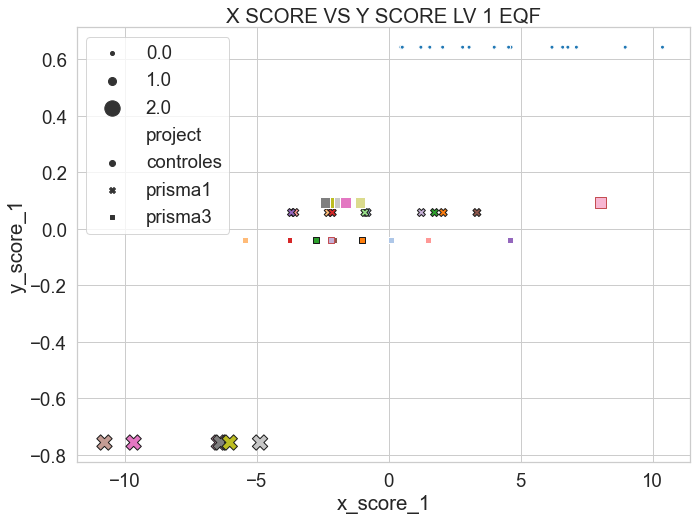

In [228]:

g=sns.scatterplot(x="x_score_1", y="y_score_1",
                 hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[20:]
selected_labels = current_labels[20:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF")
plt.show()

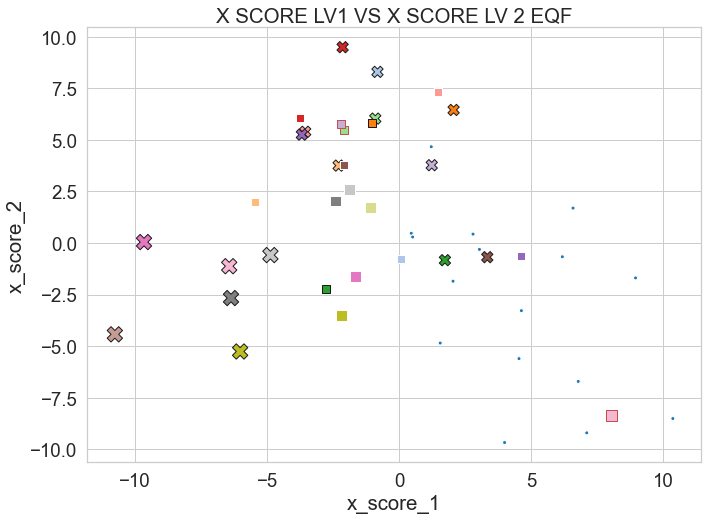

In [229]:
g=sns.scatterplot(x="x_score_1", y="x_score_2",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=False,
                palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[20:]
selected_labels = current_labels[20:]
#plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV 2 EQF")
plt.show()

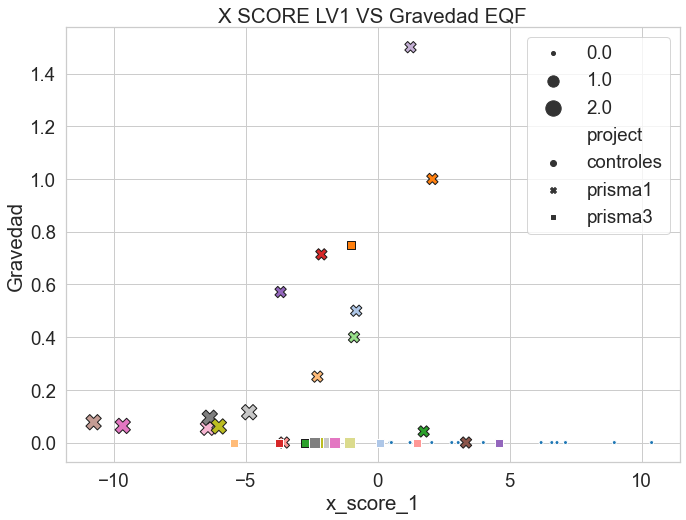

In [230]:
score_EQF_na = score_EQF.dropna(subset=['Gravedad'])
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                palette='tab20',data=score_EQF_na,edgecolor=score_EQF_na["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[20:]
selected_labels = current_labels[20:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad EQF")
plt.show()

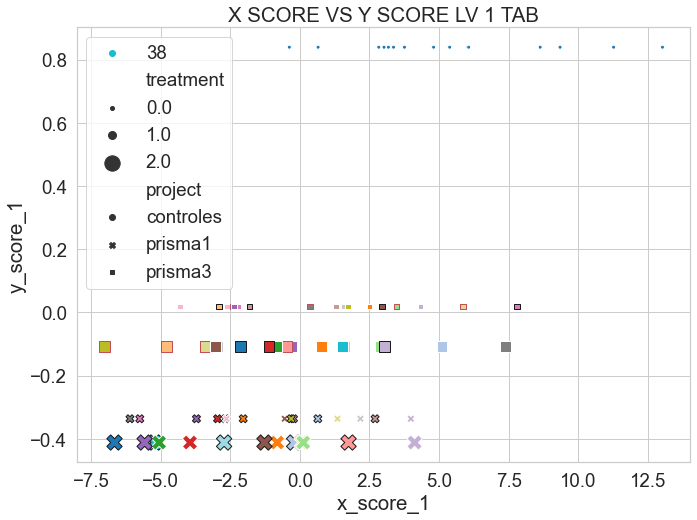

In [231]:
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                 hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[39:]
selected_labels = current_labels[39:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 TAB")
plt.show()

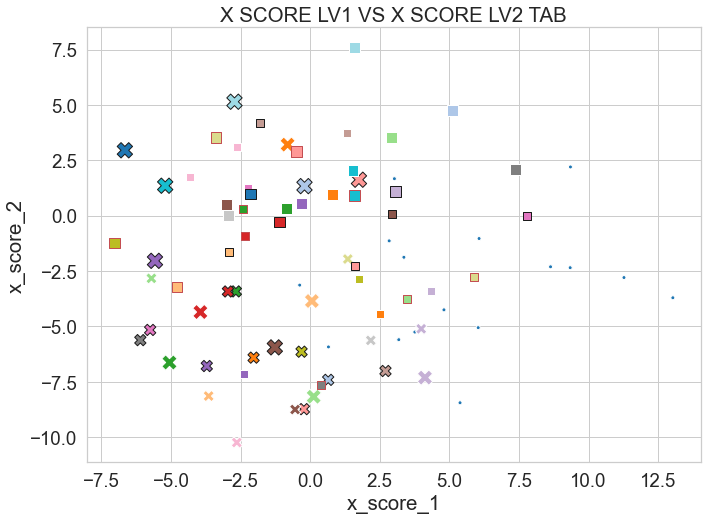

In [232]:
g= sns.scatterplot(x="x_score_1", y="x_score_2",
                hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=False,
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)

current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[39:]
selected_labels = current_labels[39:]
#plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 TAB")
plt.show()

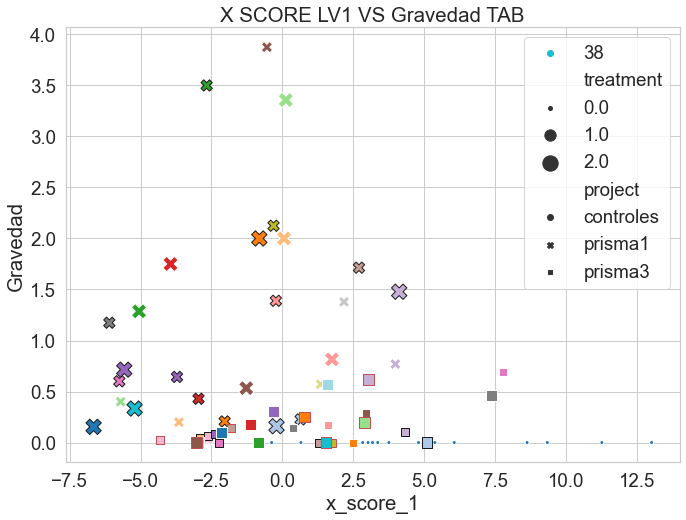

In [233]:
score_TAB_na = score_TAB.dropna(subset=['Gravedad'])
markers = {0.0: "X", 1.0: "o",2.0:"s"}
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[39:]
selected_labels = current_labels[39:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad TAB")
plt.show()

## X Weights


In [170]:
yeo_pal = {'Vis': (0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 'SomMot': (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 'DorsAttn': (0.0, 0.4627450980392157, 0.054901960784313725),
 'SalVentAttn': (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 'Limbic': (0.8627450980392157, 0.9725490196078431, 0.6431372549019608),
 'Cont': (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 'Default': (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 'None': (0.7, 0.7, 0.7, 0.5)}

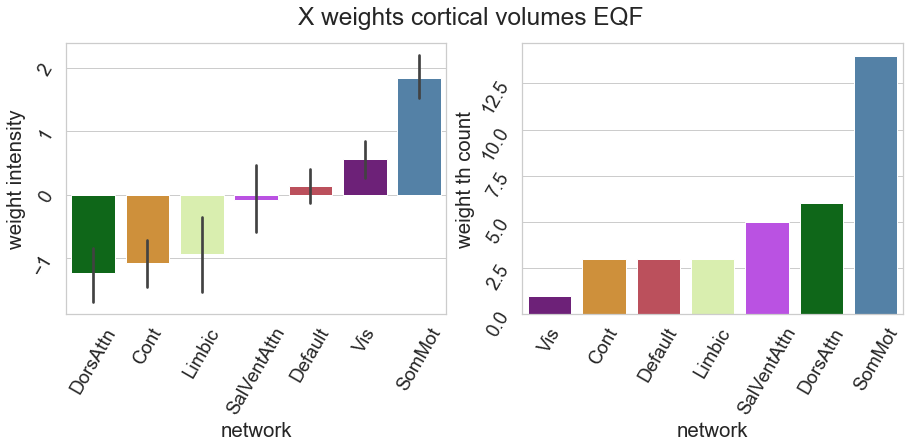

In [274]:
EQF_data = all_data_sorted_EQF.iloc[:,3:-7]
sch_x_weights_EQF = pls_EQF.bootres.x_weights_normed[:400,0]
df_x_weights_sch_EQF = pd.DataFrame(sch_x_weights_EQF, columns=["weight"])
df_x_weights_sch_EQF.index = EQF_data.columns[:400]
df_x_weights_sch_EQF["network"] = df_x_weights_sch_EQF.index.str.split('_').str.get(2)
th = 3
df_x_weights_sch_EQF["weight_th"] =  (abs(df_x_weights_sch_EQF["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF')

order_g = df_x_weights_sch_EQF.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0],palette=yeo_pal,order=order_g,
            data=df_x_weights_sch_EQF)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_EQF.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,palette=yeo_pal,order=order_h,
            data=df_x_weights_sch_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)


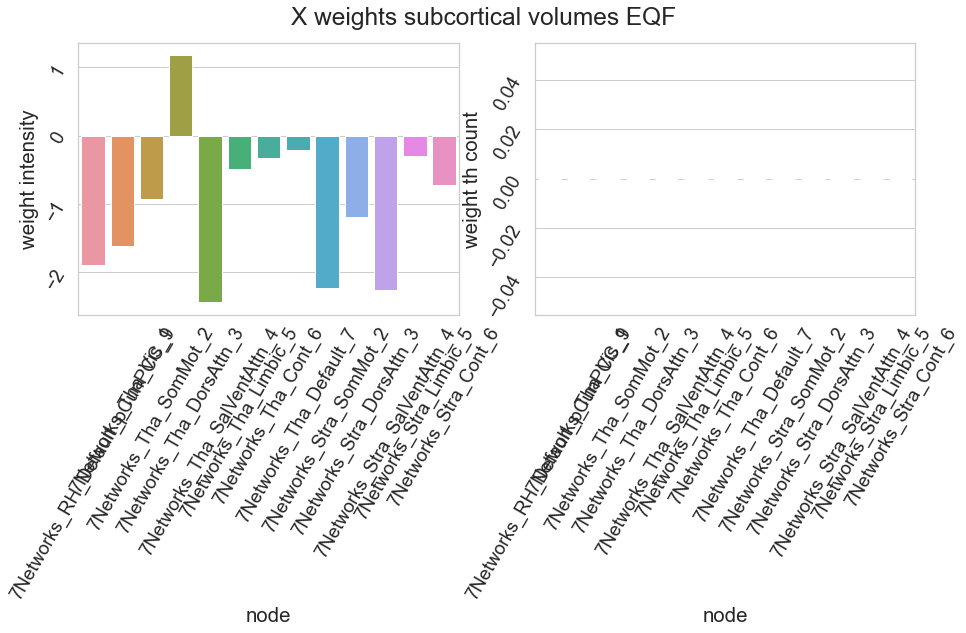

In [199]:
sch_x_v_weights_EQF = pls_EQF.bootres.x_weights_normed[400:,0]

df_x_weights_v_EQF = pd.DataFrame(sch_x_v_weights_EQF, columns=["weight"])
df_x_weights_v_EQF['node'] = list(EQF_data.iloc[:,399:412].columns)
#df_x_weights_v_EQF['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_EQF["weight_th"] =  (abs(df_x_weights_v_EQF["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes EQF')

g=sns.barplot(x="node", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_EQF)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="node", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



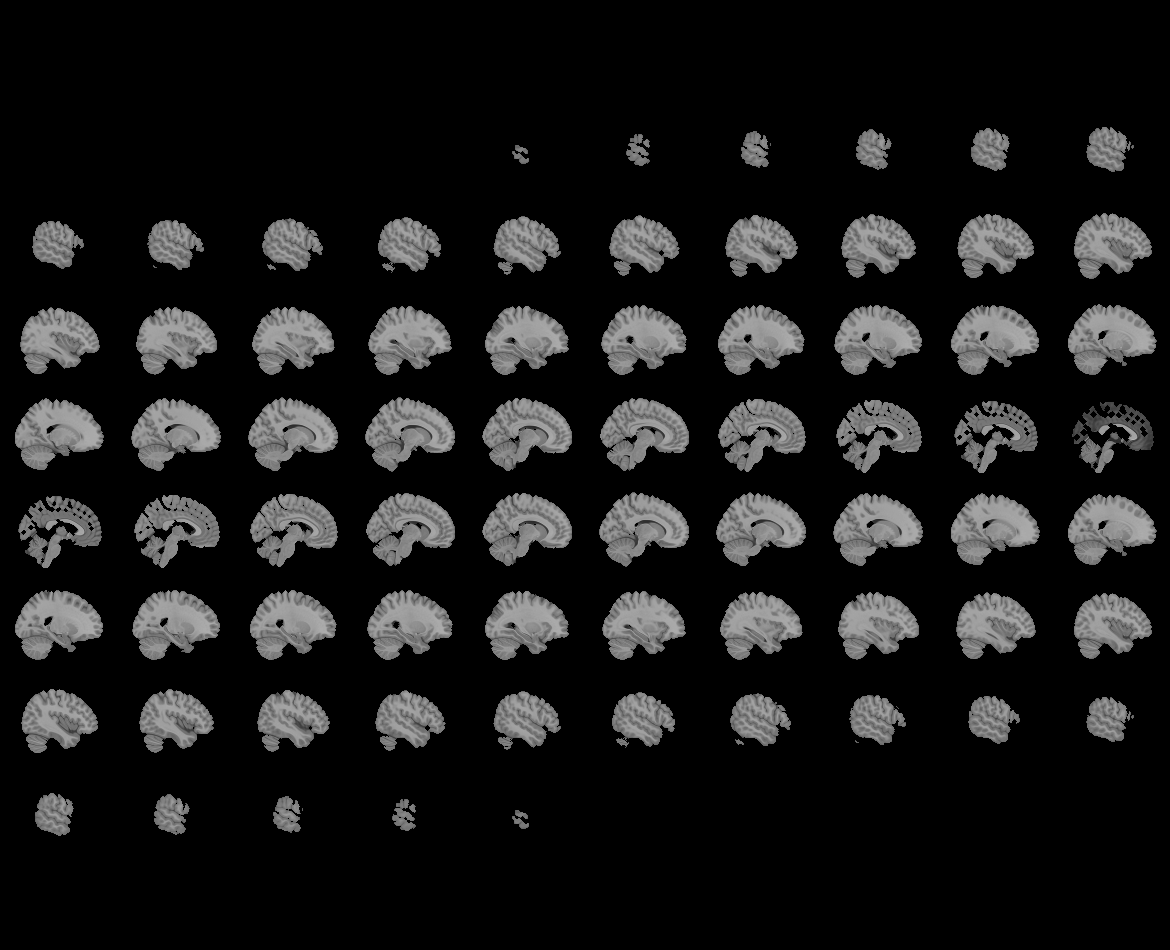
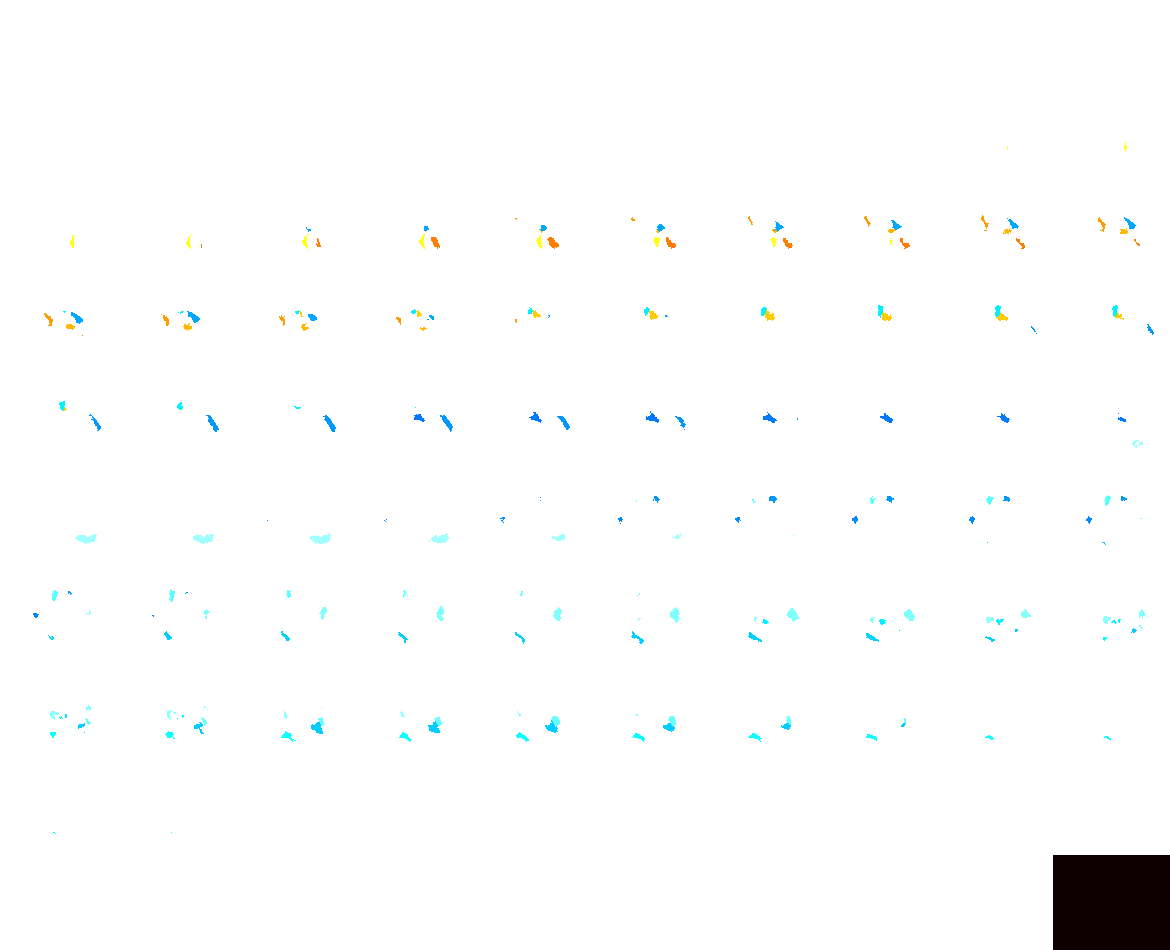

In [94]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th = max(sch_x_weights_EQF)*0.7
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_weights_EQF[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights Beh', symmetric_cmap=False)

## TAB

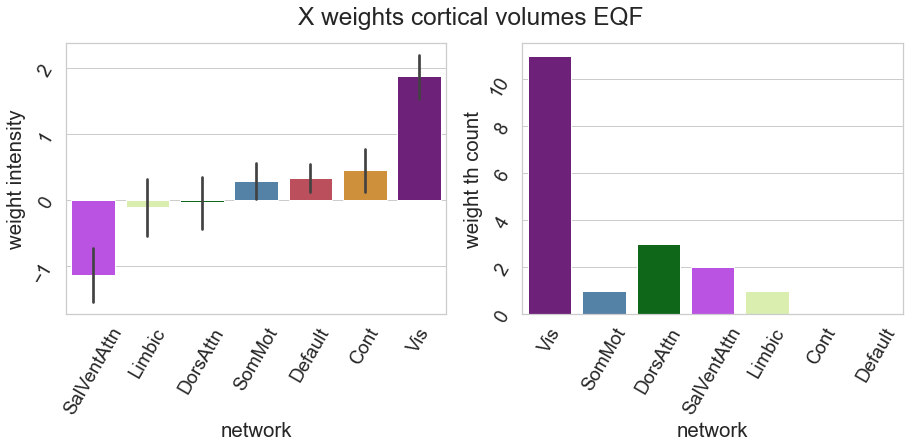

In [275]:
TAB_data = all_data_sorted_TAB.iloc[:,3:-7]
sch_x_weights_EQF = pls_TAB.bootres.x_weights_normed[:400,0]
df_x_weights_sch_TAB = pd.DataFrame(sch_x_weights_TAB, columns=["weight"])
df_x_weights_sch_TAB.index = TAB_data.columns[:400]
df_x_weights_sch_TAB["network"] = df_x_weights_sch_TAB.index.str.split('_').str.get(2)
th = 3
df_x_weights_sch_TAB["weight_th"] =  (abs(df_x_weights_sch_TAB["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF')

order_g = df_x_weights_sch_TAB.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0],palette=yeo_pal,order = order_g,
            data=df_x_weights_sch_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_TAB.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

In [260]:
order_g

Index(['SalVentAttn', 'Limbic', 'DorsAttn', 'SomMot', 'Default', 'Cont',
       'Vis'],
      dtype='object', name='network')

/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '



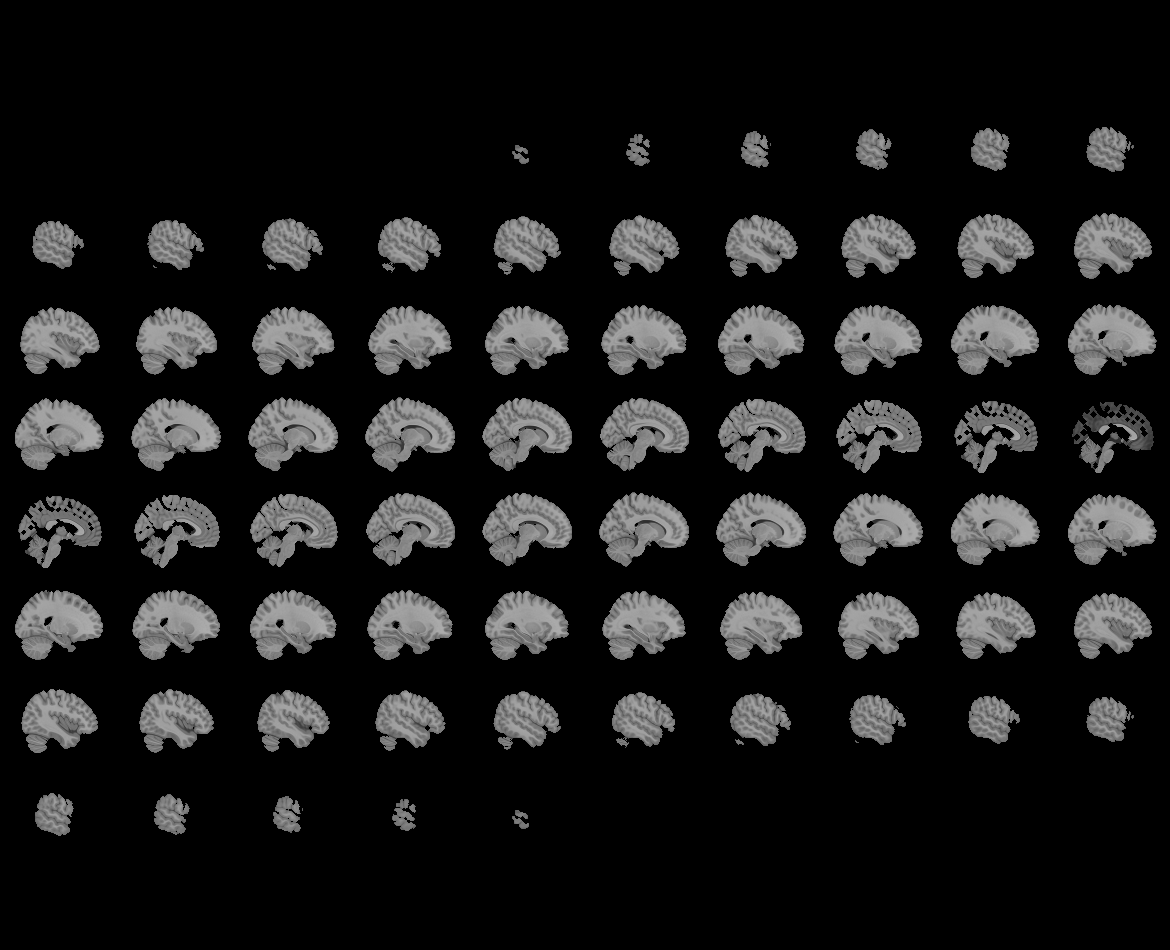
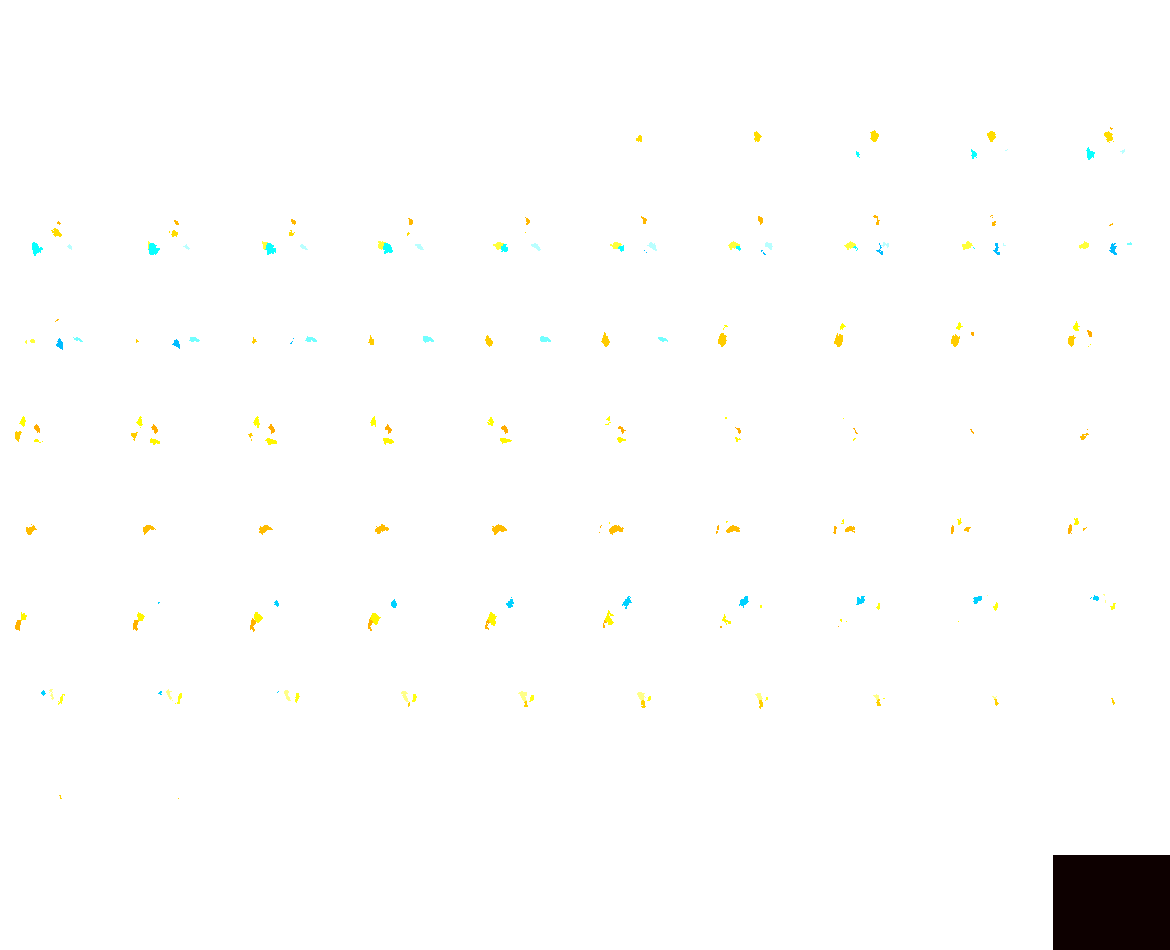

In [96]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th = max(sch_x_weights_TAB)*0.7
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_weights_TAB[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights Beh', symmetric_cmap=False)

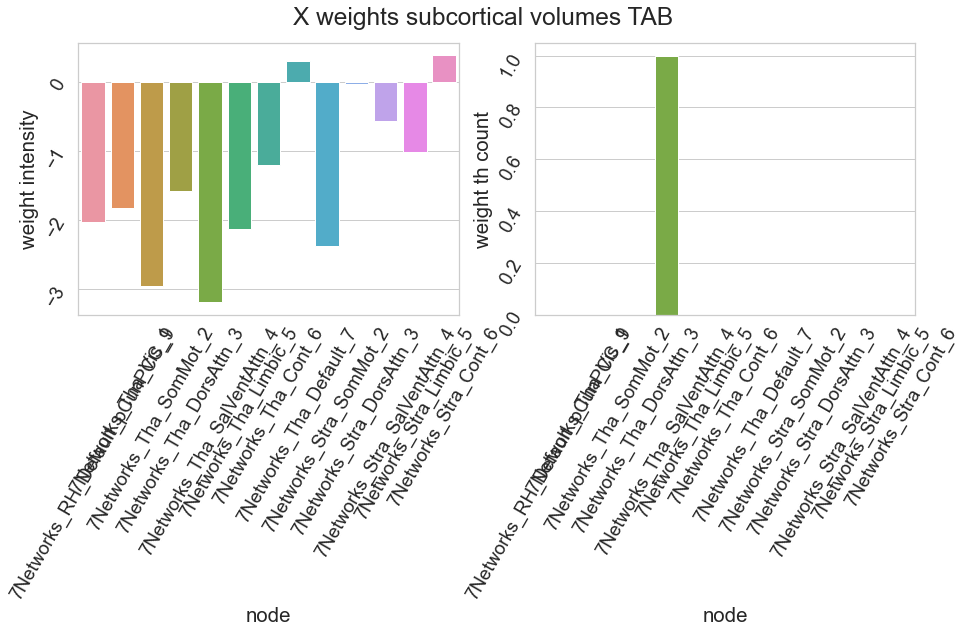

In [270]:
sch_x_v_weights_TAB = pls_TAB.bootres.x_weights_normed[400:,0]
df_x_weights_v_TAB = pd.DataFrame(sch_x_v_weights_TAB, columns=["weight"])

df_x_weights_v_TAB['node'] = list(TAB_data.iloc[:,399:412].columns)
th = 3
df_x_weights_v_TAB["weight_th"] =  (abs(df_x_weights_v_TAB["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes TAB')

g=sns.barplot(x="node", y="weight", ci=None, ax=axes[0],data=df_x_weights_v_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="node", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)